In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info import Statevector

# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

# Quantum Optimization with Qiskit
UIMP/CSIC Summer School on Quantum Computing<br>
September 1, 2020<br>
<br>

Stefan Woerner<br>
IBM Quantum, IBM Research - Zurich<br>
<br>

https://github.com/stefan-woerner/uimp_csic_2020_summer_school_on_quantum_computing

# Outline

1. Introduction

2. Qiskit's Optimization Module

3. Optimization via Ising Hamiltonians

    <font color="blue">---- break (10min) ----</font>

4. Optimization via Grover Adaptive Search

5. An Application in Finance

6. What's next...

    <font color="darkgreen">$\rightarrow$ We'll have time for questions after each section.</font>

# 1. Introduction


# "Quantum Computers can evaluate all possible solutions at the same time..."

# <font color="red">"Quantum Computers can evaluate all possible solutions at the same time..."</font>
## $\rightarrow$ A common misunderstanding, particularly for combinatorial optimization!

Suppose the equal superposition state

$$
|+\rangle_n = H^{\otimes n} |0\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n
$$

Furthermore, suppose a function $f: \{0, \ldots, 2^n-1\} \rightarrow \mathbb{R}$ and a corresponding quantum operation

$$
F: |x\rangle_n|0\rangle_m \mapsto |x\rangle_n|f(x)\rangle_m
$$

Thus, we get

$$
F |+\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n|f(x)\rangle_m
$$

and the quantum computer evaluates the exponential number of solultions in parallel! 

Doesn't it?

Unfortunately,
- it remains an exponential number of possible solutions.
- the quantum computer does NOT tell us which one achieves the optimum.
- if we measure the qubits in the state above, we just sample every possible solution with the same probability of $1/2^n$, as we could easily do classically.
<br>
<br>
<br>
<font color="orange">$\rightarrow$ To get a quantum computer to tell us the optimal solution of a combinatorial optimization problem with probability higher than $1/2^n$, we have to work a bit harder...</font>

# 2. Qiskit's Optimization Module

# Qiskit's Optimization Module

<br>
<div>
    <center>
        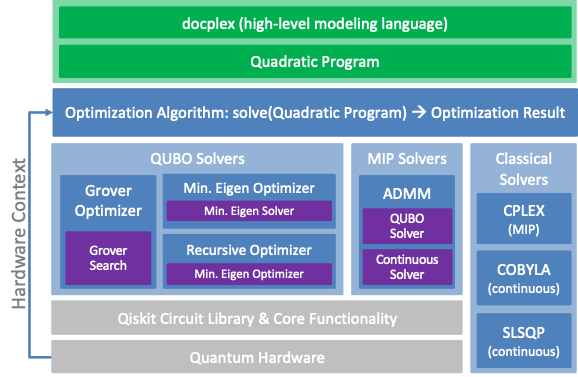
        <br>
        https://medium.com/qiskit: A Walkthrough of Qiskit’s New Optimization Module
    </center>
</div>

## Quadratically Constrained Quadratic Programs

<br>

$$
\min_{x \in X} \, x^T A x + b^T x + c \\
\,\\
\text{subject to}\\
x^T A_i x + b_i^T x + c_i \leq 0, \quad i=1, \ldots, r,\\
\,\\
\text{where}\\
X = \mathbb{R}^n \times \mathbb{Z}^m \times \{0, 1\}^k\\
A \in \mathbb{R}^{(n+m+k) \times (n+m+k)}\\
b \in \mathbb{R}^{(n+m+k)}\\
c \in \mathbb{R}
$$

## Quadratic Unconstrained Binary Optimization (QUBO)

<br>

$$
\min_{x \in \{0, 1\}^k} \, x^T A x + c \\
$$

For binary variables $x^2 = x$, thus, the linear part can be added to the diagonal of the quadratic part.

## Example: MaxCut

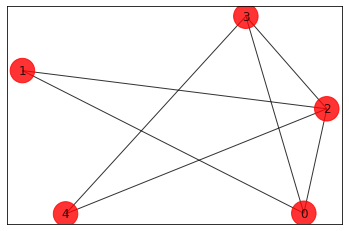

In [2]:
# create graph
G = nx.Graph()

# add nodes
n = 5
G.add_nodes_from(range(n))

# add edges: tuple is (i,j,weight) where (i,j) is the edge
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

# plot graph
plot_result(G, [0]*n)

## Example: Modeling MaxCut with DOcplex

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j)
$$

In [3]:
from docplex.mp.model import Model

mdl = Model('MaxCut')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

objective = mdl.sum([ w * (x[i] + x[j] - 2*x[i]*x[j]) for (i, j, w) in edges])
mdl.maximize(objective)

mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 [ - 2 x0*x1 - 2 x0*x2 - 2 x0*x3 - 2 x1*x2
 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 ];
 
subject to {

}


## Example: Adding a Constraint

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j) \\
\text{subject to:} \sum_{i=0}^{n-1} x_i = b
$$

In [4]:
b = 2
mdl.add_constraint(mdl.sum(x) == b)
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 [ - 2 x0*x1 - 2 x0*x2 - 2 x0*x3 - 2 x1*x2
 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 ];
 
subject to {
 x0 + x1 + x2 + x3 + x4 == 2;

}


## Example: Create and solve `QuadraticProgram` with DOcplex

optimal function value: 5.0
optimal value: [0. 0. 1. 1. 0.]
status: SUCCESS


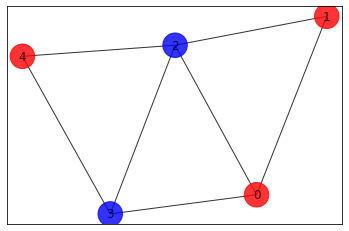

In [5]:
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer

# convert from DOcplex model to Qiskit Quadratic Program
qp = QuadraticProgram()
qp.from_docplex(mdl)

# Solve Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_result(G, result.x)

## Questions?

# 3. Optimization via Ising Hamiltonian

## Conversion to QUBO

Qiskit's Optimization module provides converters for Quadratic Programs:

In [6]:
from qiskit.optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints by adding slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo    # combines the previous three converters
)

## Linear Equality Constraint to Quadratic Penalty Term

In [7]:
lineq2penalty = LinearEqualityToPenalty(penalty=1)
qp_wo_constr = lineq2penalty.convert(qp)
qp_wo_constr

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Maximize
 obj: 7 x0 + 6 x1 + 8 x2 + 7 x3 + 6 x4 + [ - 2 x0^2 - 8 x0*x1 - 8 x0*x2
      - 8 x0*x3 - 4 x0*x4 - 2 x1^2 - 8 x1*x2 - 4 x1*x3 - 4 x1*x4 - 2 x2^2
      - 8 x2*x3 - 8 x2*x4 - 2 x3^2 - 8 x3*x4 - 2 x4^2 ]/2 -4
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End

optimal function value: 5.0
optimal value: [1. 0. 0. 0. 1.]
status: SUCCESS


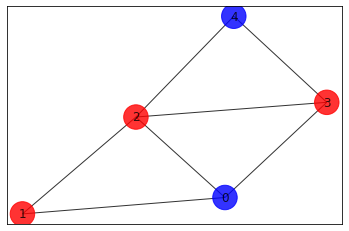

In [8]:
# Solve converted Quadratic Program using CPLEX
result = cplex.solve(qp_wo_constr)
print(result)
plot_result(G, result.x)

## Mapping of QUBO to Ising Hamiltonian

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

1. Substitute<br>
$x_i = (1 - z_i)/2,$<br>
where $z_i \in \{-1, +1\}$.
<br>

2. Replace<br>
$z_i z_j = \sigma_Z^i \otimes \sigma_Z^j$, and<br>
$z_i = \sigma_Z^i$,<br>
where $\sigma_Z^i$ denotes the Pauli Z-matrix $\left(\begin{array}{cc}1&0\\0&-1\end{array}\right)$ on the <font color="blue">$i$-th qubit</font>.

## From QUBO to Finding Hamiltonian Groundstates

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

which has been mapped to an Ising Hamiltonian:
$$
H = \sum_{i,j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i + \tilde{c}
$$

Finding the groundstate of $H$ is equivalent to solving the QUBO:

$$
\min_{|\psi\rangle_n} \, \langle \psi |H| \psi \rangle_n
$$

<br>

<b>Remark:</b> $H$ is diagonal, and thus, all computational basis states $|x\rangle_n$ are eigenstates.

In [9]:
H, offset = qp_wo_constr.to_ising()
print('offset =', offset)
print()
print('H =', H)

offset = -2.0

H = SummedOp([
  -0.5 * IIIIZ,
  -0.5 * IIIZI,
  -0.5 * IIZII,
  -0.5 * IZIII,
  -0.5 * ZIIII,
  IIIZZ,
  IIZIZ,
  IIZZI,
  IZIIZ,
  0.5 * IZIZI,
  IZZII,
  0.5 * ZIIIZ,
  0.5 * ZIIZI,
  ZIZII,
  ZZIII
])


dim(H): (32, 32)
[[ 6.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4.  0.  0.]
 [ 0.  0.  0. ...  0.  3.  0.]
 [ 0.  0.  0. ...  0.  0. 11.]]


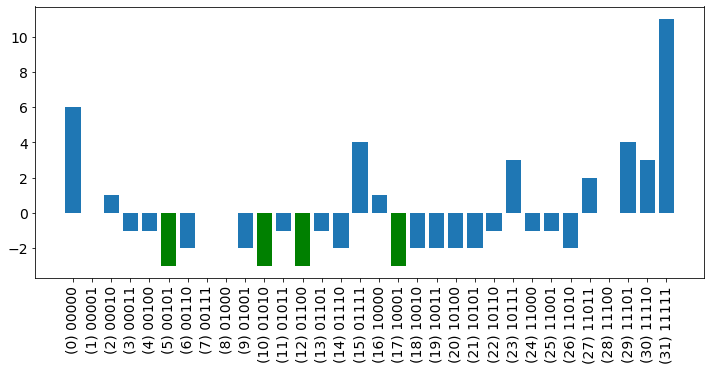

In [10]:
# print Ising Hamiltonian as matrix
H_matrix = np.real(H.to_matrix())
print('dim(H):', H_matrix.shape)
print(H_matrix)

# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Variational Quantum Eigensolver (VQE)

Replace minimization over all $|\psi\rangle$ by minimization over a parametrized subset $|\psi(\theta)\rangle$:
<br>

$$
\min_{\theta} \langle \psi(\theta) |H| \psi(\theta) \rangle
$$

## VQE with `RealAmplitudes` Circuit

In [11]:
from qiskit.circuit.library import RealAmplitudes
qc = RealAmplitudes(5, reps=1)
qc.draw(fold=120)

┌──────────┐                         ┌──────────┐                                              
q_0: ┤ RY(θ[0]) ├──■────■────■─────────■──┤ RY(θ[5]) ├──────────────────────────────────────────────
     ├──────────┤┌─┴─┐  │    │         │  └──────────┘     ┌──────────┐                             
q_1: ┤ RY(θ[1]) ├┤ X ├──┼────┼────■────┼───────■────────■──┤ RY(θ[6]) ├─────────────────────────────
     ├──────────┤└───┘┌─┴─┐  │  ┌─┴─┐  │       │        │  └──────────┘     ┌──────────┐            
q_2: ┤ RY(θ[2]) ├─────┤ X ├──┼──┤ X ├──┼───────┼────────┼───────■────────■──┤ RY(θ[7]) ├────────────
     ├──────────┤     └───┘┌─┴─┐└───┘  │     ┌─┴─┐      │     ┌─┴─┐      │  └──────────┘┌──────────┐
q_3: ┤ RY(θ[3]) ├──────────┤ X ├───────┼─────┤ X ├──────┼─────┤ X ├──────┼───────■──────┤ RY(θ[8]) ├
     ├──────────┤          └───┘     ┌─┴─┐   └───┘    ┌─┴─┐   └───┘    ┌─┴─┐   ┌─┴─┐    ├──────────┤
q_4: ┤ RY(θ[4]) ├────────────────────┤ X ├────────────┤ X ├────────────┤ X ├───┤ X ├────┤ RY(θ[9]) ├
     └──────────┘                    └───┘            └───┘            └───┘   └───┘    └──────────┘

optimal value: (-3+0j)


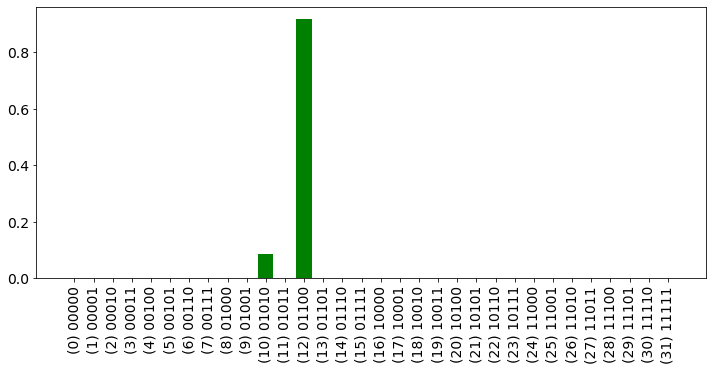

In [12]:
# run VQE
from qiskit.aqua.algorithms import VQE
vqe = VQE(H, qc, quantum_instance=Aer.get_backend('statevector_simulator'))
result = vqe.run()
print('optimal value:', np.round(result.eigenvalue, decimals=4))

# plot probabilities
probabilities = np.abs(result.eigenstate)**2
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How should we choose $|\psi(\theta)\rangle$ for a particular problem?

## The Adiabatic Theorem
> A physical system remains in its instantaneous eigenstate if a given perturbation is acting on it slowly enough and if there is a gap between the eigenvalue and the rest of the Hamiltonian's spectrum. <br><br>
> M. Born and V. A. Fock (1928). "Beweis des Adiabatensatzes".<br>Zeitschrift für Physik A. 51 (3–4): 165–180.<br>
https://en.wikipedia.org/wiki/Adiabatic_theorem

## Trotterized Annealing: General Idea

Given a cost Hamiltonian $H_C$ that encodes a QUBO:
1. Find simple Hamiltonian $H_X$ with easy-to-prepare groundstate $|\psi_0\rangle$<br>that has non-zero overlap with the groundstate of $H_C$.

2. Slowly drive the system away from $|\psi_0\rangle$ over time $t \in [0, T]$, following the dynamics defined by the time-dependent Hamiltonian
$$
H_t = \frac{t}{T} H_C + (1 - \frac{t}{T}) H_X.
$$

If done slowly enough, the Adiabatic Theorem implies that the system will stay in the groundstate of $H_t$ for all $t$. Thus, will end in the groundstate $H_C$, i.e., the optimal solution of the QUBO.

## Trotterized Annealing: Common Setting

A common choice is

$$
H_X = -\sum_{i=1}^n \sigma_X^i,
$$

where $\sigma_X^i$ denotes the Pauli X-matrix on qubit $i$.
The corresponding groundstate is given by

$$
|\psi_0\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} |k\rangle.
$$

This state has overlap with every other state and can be easily prepared using Hadamard gates.

## Trotterized Annealing: Single Qubit Example

Suppose

$$
H_C = \sigma_Z = 
\left(\begin{array}{cc}
1 & 0 \\ 0 & -1
\end{array}\right)
$$

with <font color="blue">groundstate $|1\rangle$ and optimal value -1</font>.
Then,

$$
H_t = \frac{t}{T} \sigma_Z - (1 - \frac{t}{T}) \sigma_X.
$$

The annealing process can then be approximated by setting

$$ 
|\psi_{t+1}\rangle = e^{-iH_t \Delta t}|\psi_{t}\rangle
$$

for a small time step $\Delta t$. The matrices $\sigma_Z$ and $\sigma_X$ do not commute, however, we can trotterize, i.e., we first apply $e^{-i \frac{t}{T} H_C \Delta t}$ and then $e^{-i (1 - \frac{t}{T}) H_X \Delta t}$, and for sufficiently small $\Delta t$ only introduce a small error.

Thus, we have

$$
e^{-i \frac{t}{T} H_C \Delta t} = e^{-i \sigma_Z \frac{\gamma_t}{2}} = R_Z(\gamma_t),
$$

and

$$
e^{-i (1 - \frac{t}{T}) H_X \Delta t} = e^{-i \sigma_X \frac{\beta_t}{2}} = R_X(\beta_t)
$$

for rotation angles $\gamma_t = 2 t/T \Delta t$ and $\beta_t = -2(1 - t/T) \Delta t$.

In [13]:
from qiskit.circuit import Parameter
gamma, beta = Parameter('gamma'), Parameter('beta')

qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
qc.rz(gamma, 0)
qc.rx(beta, 0)
qc.barrier()
qc.draw()

┌───┐ ░ ┌───────────┐┌──────────┐ ░ 
q_0: ┤ H ├─░─┤ RZ(gamma) ├┤ RX(beta) ├─░─
     └───┘ ░ └───────────┘└──────────┘ ░

In [14]:
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas

In [15]:
T = 5
N = 10
gammas, betas = construct_schedule(T, N)

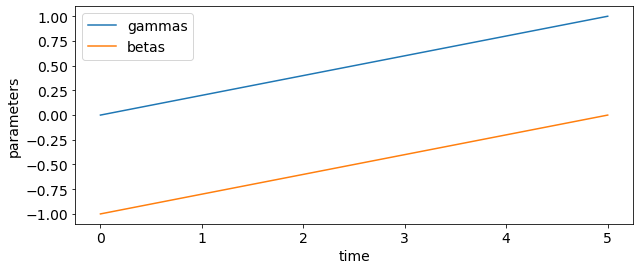

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, T, N+1), gammas, label='gammas')
plt.plot(np.linspace(0, T, N+1), betas, label='betas')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('parameters', fontsize=14);

In [17]:
# track probabilities during trotterized annealing
probabilities = np.zeros((2, N+1))

# construct circuit
qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
for i, (gamma, beta) in enumerate(zip(gammas, betas)):
    qc.rz(gamma, 0)
    qc.rx(beta, 0)
    qc.barrier()
    probabilities[:, i] = Statevector.from_instruction(qc).probabilities()
qc.draw()

┌───┐ ░ ┌───────┐┌────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐»
q_0: ┤ H ├─░─┤ RZ(0) ├┤ RX(-1) ├─░─┤ RZ(0.1) ├┤ RX(-0.9) ├─░─┤ RZ(0.2) ├»
     └───┘ ░ └───────┘└────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘»
«     ┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ »
«q_0: ┤ RX(-0.8) ├─░─┤ RZ(0.3) ├┤ RX(-0.7) ├─░─┤ RZ(0.4) ├┤ RX(-0.6) ├─░─»
«     └──────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘└──────────┘ ░ »
«     ┌─────────┐┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐»
«q_0: ┤ RZ(0.5) ├┤ RX(-0.5) ├─░─┤ RZ(0.6) ├┤ RX(-0.4) ├─░─┤ RZ(0.7) ├»
«     └─────────┘└──────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘»
«     ┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ »
«q_0: ┤ RX(-0.3) ├─░─┤ RZ(0.8) ├┤ RX(-0.2) ├─░─┤ RZ(0.9) ├┤ RX(-0.1) ├─░─»
«     └──────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘└──────────┘ ░ »
«     ┌───────┐┌───────┐ ░ 
«q_0: ┤ RZ(1) ├┤ RX(0) ├─░─
«     └───────┘└───────┘ ░

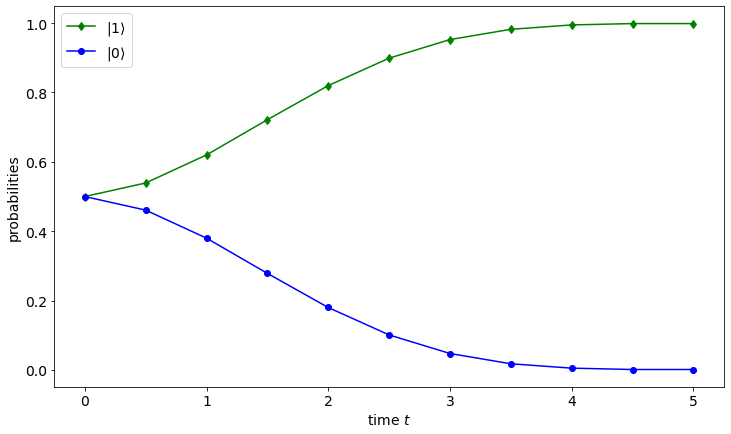

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0, T, N+1), probabilities[1, :], 'gd-', label=r'$|1\rangle$')
plt.plot(np.linspace(0, T, N+1), probabilities[0, :], 'bo-', label=r'$|0\rangle$')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('time $t$', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('probabilities', fontsize=14);

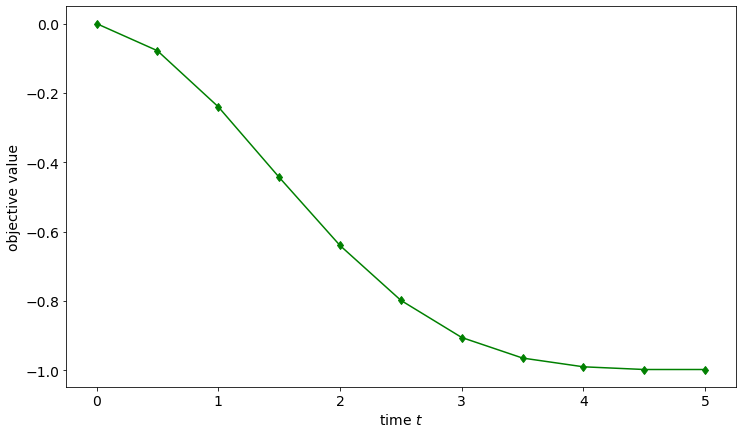

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0, T, N+1), probabilities[0, :] - probabilities[1, :], 'gd-')
plt.xticks(fontsize=14)
plt.xlabel('time $t$', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('objective value', fontsize=14);

## Trotterized Annealing: Multiple Qubits

Suppose an Ising Hamiltonian corresponding to a QUBO:
$$
H_C = \sum_{i\neq j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i.
$$
Since all terms are diagonal and commute, we have 

$$
e^{-iH_C\gamma} = \prod_{i\neq j=0}^{n-1} e^{-i \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j \gamma} \, \prod_{i=0}^{n-1} e^{-i \tilde{b}_i \sigma_Z^i \gamma}
$$

For $\sigma_Z^i$, this again results in $R_Z$ gates.

For $\sigma_Z^i \otimes \sigma_Z^j$, we need to implement
$R_{ZZ}(\gamma) = e^{-i \sigma_Z^i \otimes \sigma_Z^j \gamma/2}$.

For $H_X$ we can just apply single qubit $R_X$ gates.

$R_{ZZ}(\gamma)$ can be constructed as follows:

In [20]:
gamma = Parameter('gamma')
qc1 = QuantumCircuit(2)
qc1.cx(0, 1)
qc1.rz(gamma, 1)
qc1.cx(0, 1)
qc1.draw()

q_0: ──■─────────────────■──
     ┌─┴─┐┌───────────┐┌─┴─┐
q_1: ┤ X ├┤ RZ(gamma) ├┤ X ├
     └───┘└───────────┘└───┘

or using the implementation directly provided by Qiskit:

In [21]:
qc2 = QuantumCircuit(2)
qc2.rzz(gamma, 0, 1)
qc2.draw()

q_0: ─■──────────
      │zz(gamma) 
q_1: ─■──────────

## Trotterized Annealing: MaxCut

In [22]:
from qiskit.aqua.algorithms.minimum_eigen_solvers.qaoa.var_form import QAOAVarForm

In [23]:
# construct parameters from annealing schedule
T = 10
N = 20
gammas, betas = construct_schedule(T, N)

# construct variational form
var_form = QAOAVarForm(H, N+1)

# evaluate circuit
qc = var_form.construct_circuit(gammas + betas)
sv = Statevector.from_instruction(qc)

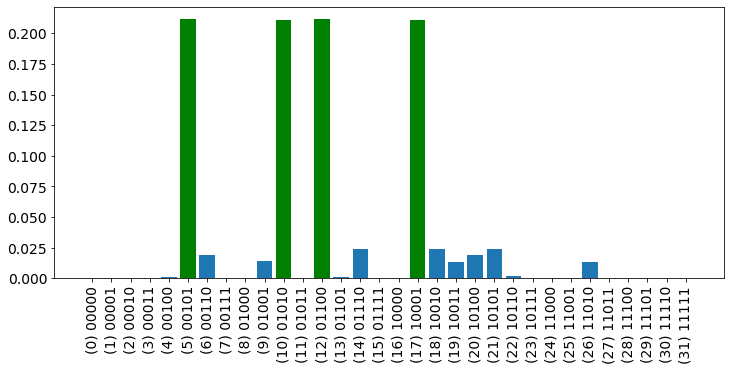

In [24]:
# plot probabilities
probabilities = sv.probabilities()
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14);

In [25]:
# draw trotterized annealing circuit for MaxCut
qc.draw()

┌───┐                                                                  »
q_0: ┤ H ├──────────────────────────────────────────────────────────────────»
     ├───┤                                      ┌───┐┌───────┐         ┌───┐»
q_1: ┤ H ├──────────────────────────────────────┤ X ├┤ RZ(0) ├─────────┤ X ├»
     ├───┤                   ┌───┐┌───────┐┌───┐└─┬─┘└─┬───┬─┘┌───────┐└─┬─┘»
q_2: ┤ H ├───────────────────┤ X ├┤ RZ(0) ├┤ X ├──┼────┤ X ├──┤ RZ(0) ├──┼──»
     ├───┤┌───┐┌───────┐┌───┐└─┬─┘└───────┘└─┬─┘  │    └─┬─┘  └───────┘  │  »
q_3: ┤ H ├┤ X ├┤ RZ(0) ├┤ X ├──┼─────────────┼────┼──────■───────────────┼──»
     ├───┤└─┬─┘└───────┘└─┬─┘  │             │    │                      │  »
q_4: ┤ H ├──■─────────────■────■─────────────■────■──────────────────────■──»
     └───┘                                                                  »
«          ┌───┐┌───────┐         ┌───┐           ┌───┐   ┌───────┐         »
«q_0: ─────┤ X ├┤ RZ(0) ├─────────┤ X ├───────────┤ X ├───┤ RZ(0) ├─────────»
«          └─┬─┘└─┬───┬─┘┌───────┐└─┬─┘  ┌───┐    └─┬─┘   └─┬───┬─┘┌───────┐»
«q_1: ───────┼────┤ X ├──┤ RZ(0) ├──┼────┤ X ├──────┼───────┤ X ├──┤ RZ(0) ├»
«     ┌───┐  │    └─┬─┘  └───────┘  │    └─┬─┘      │       └─┬─┘  └───────┘»
«q_2: ┤ X ├──┼──────┼───────────────┼──────┼────────┼─────────■─────────────»
«     └─┬─┘  │      │               │      │        │                       »
«q_3: ──■────┼──────■───────────────┼──────■────────■───────────────────────»
«            │                      │  ┌───────┐┌────────┐                  »
«q_4: ───────■──────────────────────■──┤ RZ(0) ├┤ RX(-1) ├──────────────────»
«                                      └───────┘└────────┘                  »
«     ┌───┐           ┌───┐   ┌───────┐   ┌───┐      ┌───┐  ┌───────┐ ┌───┐»
«q_0: ┤ X ├───────────┤ X ├───┤ RZ(0) ├───┤ X ├──────┤ X ├──┤ RZ(0) ├─┤ X ├»
«     └─┬─┘  ┌───┐    └─┬─┘   └───────┘   └─┬─┘      └─┬─┘  └───────┘ └─┬─┘»
«q_1: ──┼────┤ X ├──────┼───────────────────┼──────────■────────────────■──»
«       │    └─┬─┘      │                   │      ┌───────┐┌────────┐┌───┐»
«q_2: ──┼──────■────────■───────────────────■──────┤ RZ(0) ├┤ RX(-1) ├┤ X ├»
«       │  ┌───────┐┌────────┐  ┌───┐  ┌──────────┐└─┬───┬─┘└────────┘└─┬─┘»
«q_3: ──■──┤ RZ(0) ├┤ RX(-1) ├──┤ X ├──┤ RZ(0.05) ├──┤ X ├──────────────┼──»
«          └───────┘└────────┘  └─┬─┘  └──────────┘  └─┬─┘              │  »
«q_4: ────────────────────────────■────────────────────■────────────────■──»
«                                                                          »
«      ┌───────┐  ┌────────┐                                        ┌───┐»
«q_0: ─┤ RZ(0) ├──┤ RX(-1) ├────────────────────────────────────────┤ X ├»
«      ├───────┤  ├────────┤┌───┐┌───────────┐            ┌───┐     └─┬─┘»
«q_1: ─┤ RZ(0) ├──┤ RX(-1) ├┤ X ├┤ RZ(0.025) ├────────────┤ X ├───────┼──»
«     ┌┴───────┴─┐└─┬───┬──┘└─┬─┘└───┬───┬───┘┌──────────┐└─┬─┘┌───┐  │  »
«q_2: ┤ RZ(0.05) ├──┤ X ├─────┼──────┤ X ├────┤ RZ(0.05) ├──┼──┤ X ├──┼──»
«     └──────────┘  └─┬─┘     │      └─┬─┘    └──────────┘  │  └─┬─┘  │  »
«q_3: ────────────────┼───────┼────────■────────────────────┼────■────┼──»
«                     │       │                             │         │  »
«q_4: ────────────────■───────■─────────────────────────────■─────────■──»
«                                                                        »
«     ┌───────────┐             ┌───┐                  ┌───┐    ┌──────────┐»
«q_0: ┤ RZ(0.025) ├─────────────┤ X ├──────────────────┤ X ├────┤ RZ(0.05) ├»
«     └───┬───┬───┘┌───────────┐└─┬─┘    ┌───┐         └─┬─┘    └──┬───┬───┘»
«q_1: ────┤ X ├────┤ RZ(0.025) ├──┼──────┤ X ├───────────┼─────────┤ X ├────»
«         └─┬─┘    └───────────┘  │      └─┬─┘           │         └─┬─┘    »
«q_2: ──────┼─────────────────────┼────────┼─────────────┼───────────■──────»
«           │                     │        │             │                  »
«q_3: ──────■─────────────────────┼────────■─────────────■─────────────

## From Trotterized Annealing to the<br>Quantum Approximate Optimization Algorithm (QAOA)

Trotterized Annealing leads to very long circuits, since the required simulation time and number of Trotter steps significantly increases with the problem size.

Thus, as introduced in [1], one can fix the number of steps to $p$, and let a classical optimizer find the best angles $\gamma_t$ and $\beta_t$, $t = 1, \ldots, p$, instead of following a fixed annealing schedule.

This is known as the <font color="blue"><b>Quantum Approximate Optimization Algorithm</b></font>.

<br>
<br>
[1] A Quantum Approximate Optimization Algorithm.<br>Edward Farhi, Jeffrey Goldstone, Sam Gutmann.<br>
https://arxiv.org/abs/1411.4028

## QAOA: Single Qubit Example $H_C = \sigma_Z$

In [26]:
from qiskit.aqua.components.optimizers import COBYLA

In [27]:
# QAOA circuit for p = 1
gamma, beta = Parameter('gamma'), Parameter('beta')
qc = QuantumCircuit(1)
qc.h(0)
qc.rz(gamma, 0)
qc.rx(beta, 0)

def objective(params):
    qc_ = qc.bind_parameters({gamma: params[0], beta: params[1]})
    probs = Statevector.from_instruction(qc_).probabilities()
    return probs @ [1, -1]

optimizer = COBYLA()
result = optimizer.optimize(num_vars=2, objective_function=objective, initial_point=[0.5, 0.5])
print('optimal params:', np.round(result[0], decimals=4))
print('optimal value: ', np.round(result[1], decimals=4))
print('optimal state: ', np.round(Statevector.from_instruction(qc.bind_parameters(
    {gamma: result[0][0], beta: result[0][1]})).data, decimals=4))

optimal params: [-1.5708  1.5708]
optimal value:  -1.0
optimal state:  [-0.    -0.j      0.7071-0.7071j]


## QAOA: MaxCut

In [28]:
# illustrating the QAOA var form
p = 1
var_form = QAOAVarForm(H, p)
var_form.construct_circuit([gamma, beta]).draw()

┌───┐                                                           »
q_0: ┤ H ├───────────────────────────────────────────────────────────»
     ├───┤                                                      ┌───┐»
q_1: ┤ H ├──────────────────────────────────────────────────────┤ X ├»
     ├───┤                           ┌───┐┌───────────────┐┌───┐└─┬─┘»
q_2: ┤ H ├───────────────────────────┤ X ├┤ RZ(1.0*gamma) ├┤ X ├──┼──»
     ├───┤┌───┐┌───────────────┐┌───┐└─┬─┘└───────────────┘└─┬─┘  │  »
q_3: ┤ H ├┤ X ├┤ RZ(1.0*gamma) ├┤ X ├──┼─────────────────────┼────┼──»
     ├───┤└─┬─┘└───────────────┘└─┬─┘  │                     │    │  »
q_4: ┤ H ├──■─────────────────────■────■─────────────────────■────■──»
     └───┘                                                           »
«                                                 ┌───┐┌───────────────┐»
«q_0: ────────────────────────────────────────────┤ X ├┤ RZ(0.5*gamma) ├»
«     ┌───────────────┐                 ┌───┐     └─┬─┘└─────┬───┬─────┘»
«q_1: ┤ RZ(0.5*gamma) ├─────────────────┤ X ├───────┼────────┤ X ├──────»
«     └─────┬───┬─────┘┌───────────────┐└─┬─┘┌───┐  │        └─┬─┘      »
«q_2: ──────┤ X ├──────┤ RZ(1.0*gamma) ├──┼──┤ X ├──┼──────────┼────────»
«           └─┬─┘      └───────────────┘  │  └─┬─┘  │          │        »
«q_3: ────────■───────────────────────────┼────■────┼──────────■────────»
«                                         │         │                   »
«q_4: ────────────────────────────────────■─────────■───────────────────»
«                                                                       »
«                      ┌───┐                       ┌───┐      ┌───────────────┐»
«q_0: ─────────────────┤ X ├───────────────────────┤ X ├──────┤ RZ(1.0*gamma) ├»
«     ┌───────────────┐└─┬─┘      ┌───┐            └─┬─┘      └─────┬───┬─────┘»
«q_1: ┤ RZ(0.5*gamma) ├──┼────────┤ X ├──────────────┼──────────────┤ X ├──────»
«     └───────────────┘  │        └─┬─┘              │              └─┬─┘      »
«q_2: ───────────────────┼──────────┼────────────────┼────────────────■────────»
«                        │          │                │                         »
«q_3: ───────────────────┼──────────■────────────────■─────────────────────────»
«                        │  ┌────────────────┐┌──────────────┐                 »
«q_4: ───────────────────■──┤ RZ(-0.5*gamma) ├┤ RX(1.0*beta) ├─────────────────»
«                           └────────────────┘└──────────────┘                 »
«                      ┌───┐                       ┌───┐      ┌───────────────┐»
«q_0: ─────────────────┤ X ├───────────────────────┤ X ├──────┤ RZ(1.0*gamma) ├»
«     ┌───────────────┐└─┬─┘      ┌───┐            └─┬─┘      └───────────────┘»
«q_1: ┤ RZ(1.0*gamma) ├──┼────────┤ X ├──────────────┼─────────────────────────»
«     └───────────────┘  │        └─┬─┘              │                         »
«q_2: ───────────────────┼──────────■────────────────■─────────────────────────»
«                        │  ┌────────────────┐┌──────────────┐                 »
«q_3: ───────────────────■──┤ RZ(-0.5*gamma) ├┤ RX(1.0*beta) ├─────────────────»
«                           └────────────────┘└──────────────┘                 »
«q_4: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«     ┌───┐      ┌───┐       ┌───────────────┐┌───┐┌────────────────┐»
«q_0: ┤ X ├──────┤ X ├───────┤ RZ(1.0*gamma) ├┤ X ├┤ RZ(-0.5*gamma) ├»
«     └─┬─┘      └─┬─┘       └───────────────┘└─┬─┘├────────────────┤»
«q_1: ──┼──────────■────────────────────────────■──┤ RZ(-0.5*gamma) ├»
«       │  ┌────────────────┐ ┌──────────────┐     └────────────────┘»
«q_2: ──■──┤ RZ(-0.5*gamma) ├─┤ RX(1.0*beta) ├───────────────────────»
«          └────────────────┘ └──────────────┘                       »
«q_3: ───────────────────────────────────────────────────────────────»
«                                                           

In [29]:
from qiskit.aqua.algorithms import QAOA

qaoa_mes = QAOA(H, p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
result = qaoa_mes.run()

print('optimal params:      ', result.optimal_parameters)
print('optimal value:       ', result.optimal_value)
print('optimal probability: ', sum(np.abs(result.eigenstate[opt_indices])**2))

optimal params:       {Parameter(θ[0]): 0.46275581723862247, Parameter(θ[1]): -0.5702152061899909}
optimal value:        -1.7959726095370265
optimal probability:  0.2945630679279775


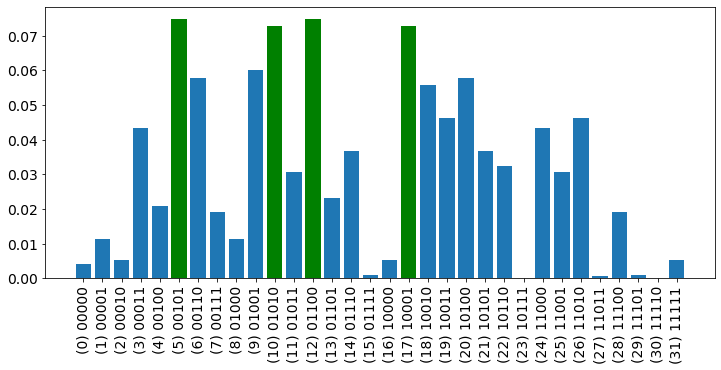

In [30]:
# plot probabilities
probabilities = np.abs(result['eigenstate'])**2
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [31]:
from qiskit.optimization.algorithms import MinimumEigenOptimizer

In [32]:
# construct QAOA as Minimum Eigensolver
qaoa_mes = QAOA(p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

# construct Minimum Eigen Optimizer based on QAOA
qaoa = MinimumEigenOptimizer(qaoa_mes)

# solve Quadratic Program
result = qaoa.solve(qp)

optimal function value: 5.0
optimal value: [1. 0. 1. 0. 0.]
status: SUCCESS


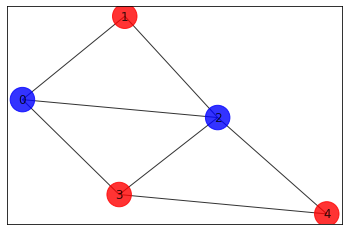

In [33]:
print(result)
plot_result(G, result.x)

## Questions?

# <font color="blue">---- break (10min) ----</font>

# 4. Optimization via Grover Adaptive Search

## Grover Search

Suppose a boolean function $f: \{0, \ldots, 2^n-1\} \rightarrow \{0, 1\}$ and an oracle $U_f$ such that

$$
U_f: |x\rangle_n \rightarrow (-1)^{f(x)} |x\rangle_n
$$

Then Grover Search allows to find an $x \in \{0, \ldots 2^n-1\}$ with $f(x)=1$ using only $\mathcal{O}(\sqrt{2^n})$ queries to the oracle, while the best classical approach requires $\mathcal{O}(2^n)$ queries to $f$.

<div align="center">
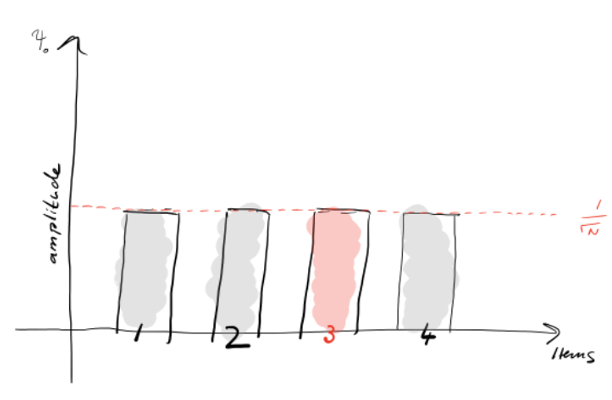
Source: https://qiskit.org/textbook/ch-algorithms/grover.html
</div>

<div align="center">
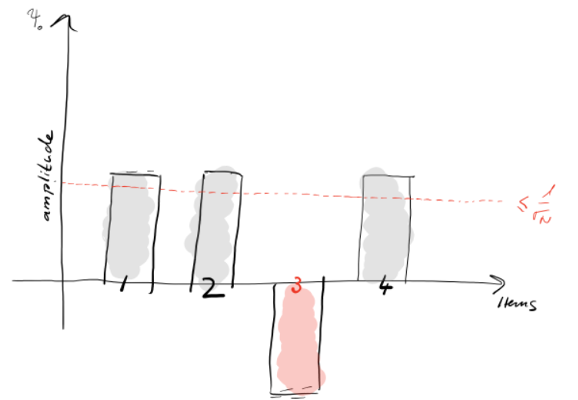
Source: https://qiskit.org/textbook/ch-algorithms/grover.html
</div>

<div align="center">
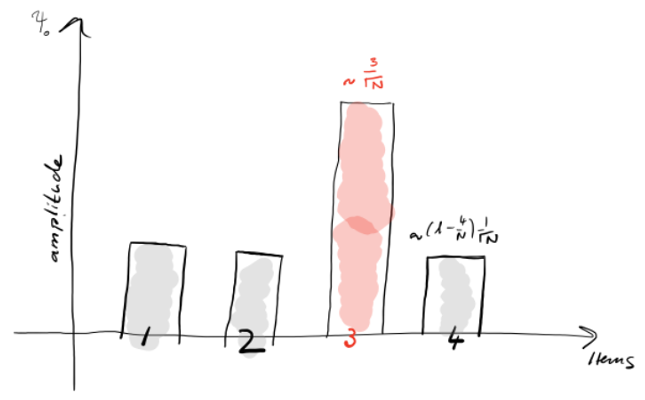
Source: https://qiskit.org/textbook/ch-algorithms/grover.html
</div>

<div align="center">
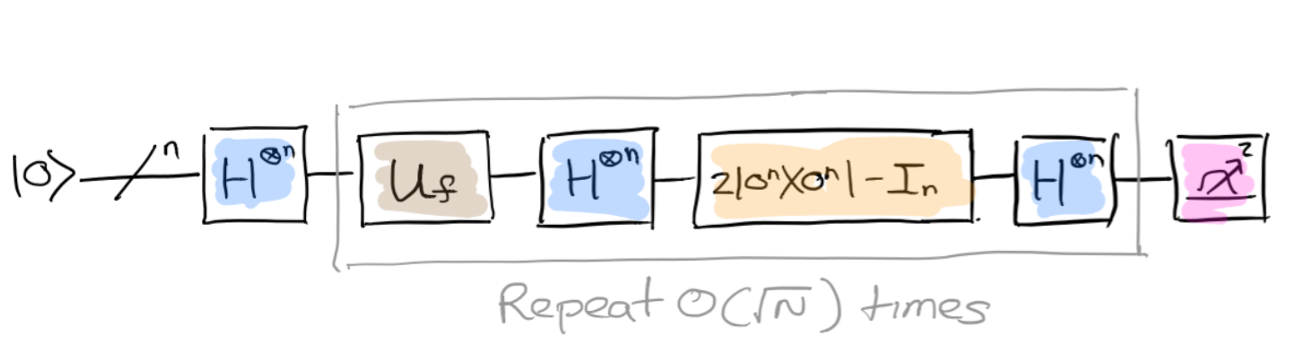
Source: https://qiskit.org/textbook/ch-algorithms/grover.html
</div>

## Grover Adaptive Search

Suppose $f: \{0, \ldots, 2^n-1\} \rightarrow \mathbb{Z}$, an input $x' \in \{0, \ldots, 2^n-1\}$, and an oracle $U_{f}(x')$ such that

$$
U_f(x'): |x\rangle_n \rightarrow (-1)^{f(x) < f(x')} |x\rangle_n
$$

1. Run Grover Search to find an $x$ with $f(x) < f(x')$.
2. Set $x' = x$ and repeat until no further improvement is made.

## How can we construct $U_f(x')$?

<div>
    <center>
        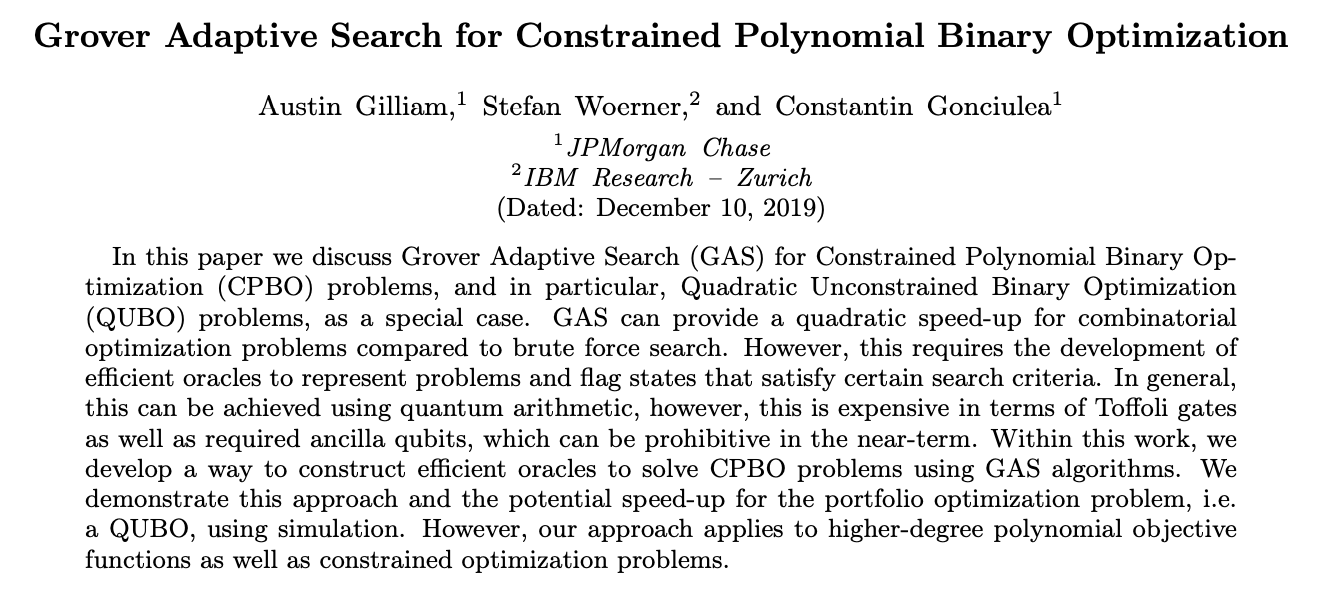
        <br>
        https://arxiv.org/abs/1912.04088
    </center>
</div>

## Two's Complement for Negative Integers

<div>
    <center>
        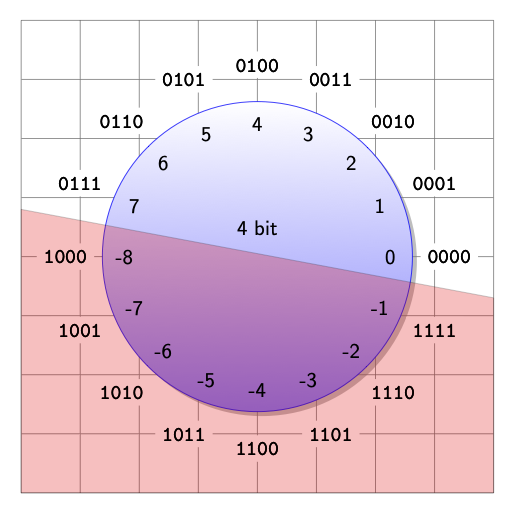
        <br>
        https://texample.net/tikz/examples/complement/
    </center>
</div>

In [34]:
# converts two's complement bit string to corresponding integer
def twos_complement(val, num_bits):
    val = int(val, 2)
    if (val & (1 << (num_bits - 1))) != 0:
        val = val - (1 << num_bits)     
    return val   

In [35]:
print(twos_complement('0011', 4))
print(twos_complement('1011', 4))

3
-5


## Phase Encoding & Quantum Fourier Transform (QFT)

For fixed $k \in \{0, \ldots, 2^n-1\}$, and starting in $|+\rangle_n$, we can construct

$$
\frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1} e^{2\pi i \frac{xk}{2^n}} |x\rangle_n = 
\bigotimes_{i=0}^{n-1} R_Z\left(2\pi \frac{2^i}{2^n} k\right) |+\rangle_n =: U_k |+\rangle_n.
$$

This implies

$$
QFT^{-1} U_k |+\rangle_n = |k\rangle_n.
$$

Furthermore, for fixed $k_1, k_2$ we get 

$$
QFT^{-1} U_{k_2} U_{k_1} |+\rangle_n = |k_1 + k_2\rangle_n.
$$

In [36]:
from qiskit.circuit.library import QFT

In [37]:
def encode(num_qubits, k):
    qc = QuantumCircuit(num_qubits, name='enc({})'.format(k))
    for i in range(num_qubits):
        theta = 2*np.pi * 2**i / 2**num_qubits * k
        qc.rz(theta, i)
    return qc

In [38]:
num_value_qubits = 4
qc = QuantumCircuit(num_value_qubits, num_value_qubits)
qc.h(range(num_value_qubits))
qc.barrier()
qc.append(encode(num_value_qubits, 2), range(num_value_qubits))
qc.barrier()
qc.append(QFT(num_value_qubits, do_swaps=False).inverse(), qc.qubits)
qc.measure(qc.qregs[0], qc.cregs[0][::-1])
qc.draw(fold=120)

┌───┐ ░ ┌─────────┐ ░ ┌───────┐┌─┐         
q_0: ┤ H ├─░─┤0        ├─░─┤0      ├┤M├─────────
     ├───┤ ░ │         │ ░ │       │└╥┘┌─┐      
q_1: ┤ H ├─░─┤1        ├─░─┤1      ├─╫─┤M├──────
     ├───┤ ░ │  enc(2) │ ░ │  iqft │ ║ └╥┘┌─┐   
q_2: ┤ H ├─░─┤2        ├─░─┤2      ├─╫──╫─┤M├───
     ├───┤ ░ │         │ ░ │       │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─░─┤3        ├─░─┤3      ├─╫──╫──╫─┤M├
     └───┘ ░ └─────────┘ ░ └───────┘ ║  ║  ║ └╥┘
c: 4/════════════════════════════════╩══╩══╩══╩═
                                     3  2  1  0

In [39]:
num_value_qubits = 4
qc = QuantumCircuit(num_value_qubits, num_value_qubits)
qc.h(range(num_value_qubits))
qc.barrier()
qc.extend(encode(num_value_qubits, 2))
# qc.extend(encode(num_value_qubits, -3))
# qc.extend(encode(num_value_qubits, 4))
qc.barrier()
qc.append(QFT(num_value_qubits, do_swaps=False, inverse=True), qc.qubits)
qc.measure(qc.qregs[0], qc.cregs[0][::-1])
qc.draw(fold=120)

┌───┐ ░ ┌──────────┐ ░ ┌──────┐┌─┐         
q_0: ┤ H ├─░─┤ RZ(pi/4) ├─░─┤0     ├┤M├─────────
     ├───┤ ░ ├──────────┤ ░ │      │└╥┘┌─┐      
q_1: ┤ H ├─░─┤ RZ(pi/2) ├─░─┤1     ├─╫─┤M├──────
     ├───┤ ░ └┬────────┬┘ ░ │  qft │ ║ └╥┘┌─┐   
q_2: ┤ H ├─░──┤ RZ(pi) ├──░─┤2     ├─╫──╫─┤M├───
     ├───┤ ░ ┌┴────────┤  ░ │      │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─░─┤ RZ(2pi) ├──░─┤3     ├─╫──╫──╫─┤M├
     └───┘ ░ └─────────┘  ░ └──────┘ ║  ║  ║ └╥┘
c: 4/════════════════════════════════╩══╩══╩══╩═
                                     3  2  1  0

In [40]:
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
for key in counts:
    print(key, ' -->', twos_complement(key, num_value_qubits))

0010  --> 2


In [41]:
num_input_qubits = 3
num_total_qubits = num_input_qubits + num_value_qubits
qc = QuantumCircuit(num_total_qubits)
qc.h([0, 1, 2])
qc.barrier()
qc.h(range(num_input_qubits, num_total_qubits))
qc.append(encode(num_value_qubits,  2).control(2), [0, 2] + list(range(num_input_qubits, num_total_qubits)))
qc.append(encode(num_value_qubits, -3).control(), [1] + list(range(num_input_qubits, num_total_qubits)))
qc.append(encode(num_value_qubits,  4).control(), [2] + list(range(num_input_qubits, num_total_qubits)))
qc.append(QFT(num_value_qubits, do_swaps=False).inverse(), range(num_input_qubits, num_total_qubits))
qc.measure_all()
qc.draw(fold=120)

┌───┐ ░      ┌───────────┐                                     ░ ┌─┐                  
   q_0: ┤ H ├─░──────┤0          ├─────────────────────────────────────░─┤M├──────────────────
        ├───┤ ░      │           │┌────────────┐                       ░ └╥┘┌─┐               
   q_1: ┤ H ├─░──────┤           ├┤0           ├───────────────────────░──╫─┤M├───────────────
        ├───┤ ░      │           ││            │┌───────────┐          ░  ║ └╥┘┌─┐            
   q_2: ┤ H ├─░──────┤1          ├┤            ├┤0          ├──────────░──╫──╫─┤M├────────────
        └───┘ ░ ┌───┐│           ││            ││           │┌───────┐ ░  ║  ║ └╥┘┌─┐         
   q_3: ──────░─┤ H ├┤2 c_enc(2) ├┤1           ├┤1          ├┤0      ├─░──╫──╫──╫─┤M├─────────
              ░ ├───┤│           ││  c_enc(-3) ││           ││       │ ░  ║  ║  ║ └╥┘┌─┐      
   q_4: ──────░─┤ H ├┤3          ├┤2           ├┤2 c_enc(4) ├┤1      ├─░──╫──╫──╫──╫─┤M├──────
              ░ ├───┤│           ││            ││           ││  iqft │ ░  ║  ║  ║  ║ └╥┘┌─┐   
   q_5: ──────░─┤ H ├┤4          ├┤3           ├┤3          ├┤2      ├─░──╫──╫──╫──╫──╫─┤M├───
              ░ ├───┤│           ││            ││           ││       │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_6: ──────░─┤ H ├┤5          ├┤4           ├┤4          ├┤3      ├─░──╫──╫──╫──╫──╫──╫─┤M├
              ░ └───┘└───────────┘└────────────┘└───────────┘└───────┘ ░  ║  ║  ║  ║  ║  ║ └╥┘
meas: 7/══════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩═
                                                                          0  1  2  3  4  5  6

In [42]:
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
for key, value in counts.items():
    x = key[num_value_qubits:]
    y_bin = key[:num_value_qubits][::-1]
    y_int = twos_complement(y_bin, num_value_qubits)
    print(x, '-->', y_bin, '-->', y_int, '\t(counts: {})'.format(value))

000 --> 0000 --> 0 	(counts: 147)
001 --> 0000 --> 0 	(counts: 126)
100 --> 0100 --> 4 	(counts: 121)
101 --> 0110 --> 6 	(counts: 127)
110 --> 0001 --> 1 	(counts: 126)
010 --> 1101 --> -3 	(counts: 137)
011 --> 1101 --> -3 	(counts: 100)
111 --> 0011 --> 3 	(counts: 140)


## What is this circuit actually doing?

For the input $x \in \{0, 1\}^3$, this circuit computes the function 

$$
Q(x) = 2 x_0 x_2 - 3 x_1 + 4 x_2
$$

This provides a systematic approach to construct arithmetic circuits for arbitrary polynomials in binary variables.<br>
<br>
This is particularly suited to evaluate the objective function of QUBOs!

In [43]:
from qiskit.circuit.library import QuadraticForm

In [44]:
# get quadratic / linear / constant part of quadratic program
A = qp_wo_constr.objective.quadratic.to_array()
b = qp_wo_constr.objective.linear.to_array()
c = qp_wo_constr.objective.constant

# set number of results qubits
num_value_qubits = 5

# construct circuit to evaluate quadratic form
qf = QuadraticForm(num_value_qubits, A, b, c)
qf.draw(fold=115)

»
q38_0: ───────────────────■───────■────────────────■────────────────────────■─────────────────────────────■────»
                          │       │                │                        │                             │    »
q38_1: ───────────────────┼───────┼───────■────────┼───────■────────────────┼─────■───────────────────────┼────»
                          │       │       │        │       │                │     │                       │    »
q38_2: ───────────────────┼───────┼───────┼────────┼───────┼───────■────────┼─────┼───────■───────────────┼────»
                          │       │       │        │       │       │        │     │       │               │    »
q38_3: ───────────────────┼───────┼───────┼────────┼───────┼───────┼────────┼─────┼───────┼───────■───────┼────»
                          │       │       │        │       │       │        │     │       │       │       │    »
q38_4: ───────────────────┼───────┼───────┼────────┼───────┼───────┼────────┼─────┼───────┼───────┼───────┼────»
       ┌───┐ ┌──────────┐ │       │       │        │       │       │        │     │       │       │       │6pi »
q39_0: ┤ H ├─┤ U1(-4pi) ├─┼───────┼───────┼────────┼───────┼───────┼────────┼─────┼───────┼───────┼───────■────»
       ├───┤ ├──────────┤ │       │       │        │       │       │        │3pi  │       │       │            »
q39_1: ┤ H ├─┤ U1(-2pi) ├─┼───────┼───────┼────────┼───────┼───────┼────────■─────┼───────┼───────┼────────────»
       ├───┤ ├─────────┬┘ │       │       │        │3pi/2  │       │              │5pi/4  │       │            »
q39_2: ┤ H ├─┤ U1(-pi) ├──┼───────┼───────┼────────■───────┼───────┼──────────────■───────┼───────┼────────────»
       ├───┤┌┴─────────┴┐ │       │3pi/4  │                │5pi/8  │                      │7pi/8  │            »
q39_3: ┤ H ├┤ U1(-pi/2) ├─┼───────■───────┼────────────────■───────┼──────────────────────■───────┼────────────»
       ├───┤├───────────┤ │3pi/8          │5pi/16                  │7pi/16                        │3pi/8       »
q39_4: ┤ H ├┤ U1(-pi/4) ├─■───────────────■────────────────────────■──────────────────────────────■────────────»
       └───┘└───────────┘                                                                                      »
«                                                                                                                »
«q38_0: ────────────────────────────────────────────────────────────────────────────────────■────────────────────»
«                                                                                           │                    »
«q38_1: ─■────────────────────────────────■─────────────────────────────────────────────────■────────────────────»
«        │                                │                                                 │                    »
«q38_2: ─┼───────■────────────────────────┼─────■───────────────────────■───────────────────┼────────────────────»
«        │       │                        │     │                       │                   │                    »
«q38_3: ─┼───────┼───────■────────────────┼─────┼───────■───────────────┼─────■─────────────┼───────■────────────»
«        │       │       │                │     │       │               │     │             │       │            »
«q38_4: ─┼───────┼───────┼───────■────────┼─────┼───────┼───────■───────┼─────┼─────■───────┼───────┼─────■──────»
«        │       │       │       │        │5pi  │       │       │       │7pi  │     │       │       │6pi  │      »
«q39_0: ─┼───────┼───────┼───────┼────────■─────┼───────┼───────┼───────■─────┼─────┼───────┼───────■─────┼──────»
«        │5pi/2  │       │       │              │7pi/2  │       │             │3pi  │       │             │5pi/2 »
«q39_1: ─■───────┼───────┼───────┼──────────────■───────┼───────┼─────────────■─────┼───────┼─────────────■──────»
«                │7pi/4  │       │                      │3pi/2  │                   │5pi/4  │                    »
«q39_2: ─────

In [45]:
qc = QuantumCircuit(n + num_value_qubits)
qc.h(range(n))
qc.append(qf, range(n + num_value_qubits))
qc.measure_all()
qc.draw()

┌───┐┌───────┐ ░ ┌─┐                           
    q_0: ┤ H ├┤0      ├─░─┤M├───────────────────────────
         ├───┤│       │ ░ └╥┘┌─┐                        
    q_1: ┤ H ├┤1      ├─░──╫─┤M├────────────────────────
         ├───┤│       │ ░  ║ └╥┘┌─┐                     
    q_2: ┤ H ├┤2      ├─░──╫──╫─┤M├─────────────────────
         ├───┤│       │ ░  ║  ║ └╥┘┌─┐                  
    q_3: ┤ H ├┤3      ├─░──╫──╫──╫─┤M├──────────────────
         ├───┤│       │ ░  ║  ║  ║ └╥┘┌─┐               
    q_4: ┤ H ├┤4      ├─░──╫──╫──╫──╫─┤M├───────────────
         └───┘│  Q(x) │ ░  ║  ║  ║  ║ └╥┘┌─┐            
    q_5: ─────┤5      ├─░──╫──╫──╫──╫──╫─┤M├────────────
              │       │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐         
    q_6: ─────┤6      ├─░──╫──╫──╫──╫──╫──╫─┤M├─────────
              │       │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
    q_7: ─────┤7      ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├──────
              │       │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
    q_8: ─────┤8      ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
              │       │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
    q_9: ─────┤9      ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
              └───────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 10/══════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                           0  1  2  3  4  5  6  7  8  9

In [46]:
counts = execute(qc, backend=Aer.get_backend('qasm_simulator')).result().get_counts()
for key, value in counts.items():
    x_ = key[num_value_qubits:]
    x = [0 if x__ == '0' else 1 for x__ in x_][::-1]
    y_bin = key[:num_value_qubits]
    y_int = twos_complement(y_bin, num_value_qubits)
    qx = qp_wo_constr.objective.evaluate(x)    
    print('x =', x_, '\ty_bin =', y_bin, '\ty_int =', y_int, '\tQ(x) =', qx, '\t(counts: {})'.format(value))

x = 11011 	y_bin = 00000 	y_int = 0 	Q(x) = 0.0 	(counts: 26)
x = 00010 	y_bin = 00001 	y_int = 1 	Q(x) = 1.0 	(counts: 28)
x = 11111 	y_bin = 10111 	y_int = -9 	Q(x) = -9.0 	(counts: 38)
x = 10000 	y_bin = 00001 	y_int = 1 	Q(x) = 1.0 	(counts: 29)
x = 00000 	y_bin = 11100 	y_int = -4 	Q(x) = -4.0 	(counts: 36)
x = 01111 	y_bin = 11110 	y_int = -2 	Q(x) = -2.0 	(counts: 22)
x = 11101 	y_bin = 11110 	y_int = -2 	Q(x) = -2.0 	(counts: 36)
x = 10111 	y_bin = 11111 	y_int = -1 	Q(x) = -1.0 	(counts: 33)
x = 11110 	y_bin = 11111 	y_int = -1 	Q(x) = -1.0 	(counts: 32)
x = 00001 	y_bin = 00010 	y_int = 2 	Q(x) = 2.0 	(counts: 26)
x = 00111 	y_bin = 00010 	y_int = 2 	Q(x) = 2.0 	(counts: 33)
x = 01000 	y_bin = 00010 	y_int = 2 	Q(x) = 2.0 	(counts: 34)
x = 11100 	y_bin = 00010 	y_int = 2 	Q(x) = 2.0 	(counts: 40)
x = 00011 	y_bin = 00011 	y_int = 3 	Q(x) = 3.0 	(counts: 36)
x = 00100 	y_bin = 00011 	y_int = 3 	Q(x) = 3.0 	(counts: 21)
x = 01011 	y_bin = 00011 	y_int = 3 	Q(x) = 3.0 	(counts: 

## How does this link to Grover Adaptive Search?

1. We have a single qubit that indicates whether a value is negative or not. 
2. We can add an offset to the objective to adjust the oracle in each iteration for changing $x'$.

In [47]:
qc = QuantumCircuit(n + num_value_qubits, name='U_f')
qc.append(qf, range(n + num_value_qubits))            # 1. compute Q(x)
qc.z(qc.qubits[-1])                                   # 2. multiply all |x>|Q(x)> by -1 where Q(x) < 0.
qc.append(qf.inverse(), range(n + num_value_qubits))  # 3. uncompute Q(x).
qc.draw()

┌───────┐     ┌──────────┐
q_0: ┤0      ├─────┤0         ├
     │       │     │          │
q_1: ┤1      ├─────┤1         ├
     │       │     │          │
q_2: ┤2      ├─────┤2         ├
     │       │     │          │
q_3: ┤3      ├─────┤3         ├
     │       │     │          │
q_4: ┤4      ├─────┤4         ├
     │  Q(x) │     │  Q(x)_dg │
q_5: ┤5      ├─────┤5         ├
     │       │     │          │
q_6: ┤6      ├─────┤6         ├
     │       │     │          │
q_7: ┤7      ├─────┤7         ├
     │       │     │          │
q_8: ┤8      ├─────┤8         ├
     │       │┌───┐│          │
q_9: ┤9      ├┤ Z ├┤9         ├
     └───────┘└───┘└──────────┘

In [48]:
qc_grover = QuantumCircuit(n + num_value_qubits)
qc_grover.h(range(n))
qc_grover.append(qc, range(qc_grover.num_qubits))
qc_grover.draw()

┌───┐┌──────┐
q_0: ┤ H ├┤0     ├
     ├───┤│      │
q_1: ┤ H ├┤1     ├
     ├───┤│      │
q_2: ┤ H ├┤2     ├
     ├───┤│      │
q_3: ┤ H ├┤3     ├
     ├───┤│      │
q_4: ┤ H ├┤4     ├
     └───┘│  U_f │
q_5: ─────┤5     ├
          │      │
q_6: ─────┤6     ├
          │      │
q_7: ─────┤7     ├
          │      │
q_8: ─────┤8     ├
          │      │
q_9: ─────┤9     ├
          └──────┘

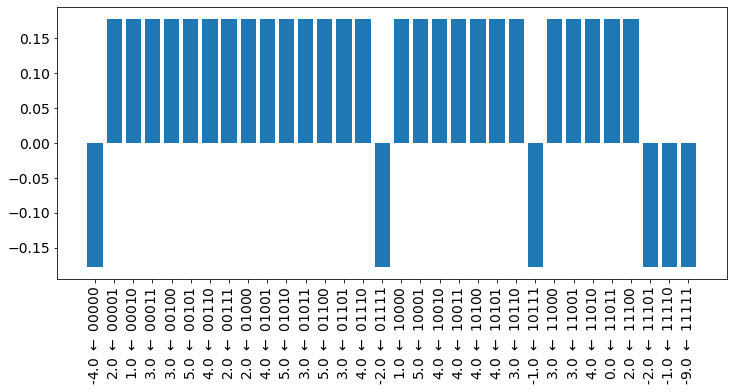

In [49]:
data = Statevector.from_instruction(qc_grover).data
x = ['{0:05b}'.format(i) for i in range(2**n)]
y = [qp_wo_constr.objective.evaluate([0 if x__ == '0' else 1 for x__ in reversed(x_)]) for x_ in x]
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), np.real(data[:2**n]))
plt.xticks(range(2**n), ['{} $\leftarrow$ '.format(y[i]) + '{0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [50]:
reflection = QuantumCircuit(n, name='reflection')
reflection.h(range(reflection.num_qubits))
reflection.barrier()
reflection.x(range(reflection.num_qubits))
reflection.barrier()
reflection.h(-1)
reflection.mct(list(range(reflection.num_qubits - 1)), -1)
reflection.h(-1)
reflection.barrier()
reflection.x(range(reflection.num_qubits))
reflection.barrier()
reflection.h(range(reflection.num_qubits))
reflection.draw()

┌───┐ ░ ┌───┐ ░                 ░ ┌───┐ ░ ┌───┐
q_0: ┤ H ├─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├
     ├───┤ ░ ├───┤ ░        │        ░ ├───┤ ░ ├───┤
q_1: ┤ H ├─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├
     ├───┤ ░ ├───┤ ░        │        ░ ├───┤ ░ ├───┤
q_2: ┤ H ├─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├
     ├───┤ ░ ├───┤ ░        │        ░ ├───┤ ░ ├───┤
q_3: ┤ H ├─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├
     ├───┤ ░ ├───┤ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤ ░ ├───┤
q_4: ┤ H ├─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├
     └───┘ ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘

In [51]:
qc_grover.append(reflection, range(n))
qc_grover.draw()

┌───┐┌──────┐┌─────────────┐
q_0: ┤ H ├┤0     ├┤0            ├
     ├───┤│      ││             │
q_1: ┤ H ├┤1     ├┤1            ├
     ├───┤│      ││             │
q_2: ┤ H ├┤2     ├┤2 reflection ├
     ├───┤│      ││             │
q_3: ┤ H ├┤3     ├┤3            ├
     ├───┤│      ││             │
q_4: ┤ H ├┤4     ├┤4            ├
     └───┘│  U_f │└─────────────┘
q_5: ─────┤5     ├───────────────
          │      │               
q_6: ─────┤6     ├───────────────
          │      │               
q_7: ─────┤7     ├───────────────
          │      │               
q_8: ─────┤8     ├───────────────
          │      │               
q_9: ─────┤9     ├───────────────
          └──────┘

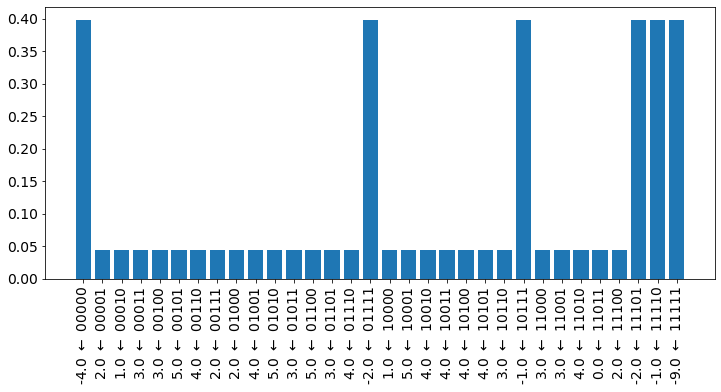

In [52]:
data = Statevector.from_instruction(qc_grover).data
x = ['{0:05b}'.format(i) for i in range(2**n)]
y = [qp_wo_constr.objective.evaluate([0 if x__ == '0' else 1 for x__ in reversed(x_)]) for x_ in x]
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), -np.real(data[:2**n]))  # multiply by -1, since reflection is implemented up to global phase -1
plt.xticks(range(2**n), ['{} $\leftarrow$ '.format(y[i]) + '{0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [53]:
from qiskit.optimization.algorithms import GroverOptimizer

In [54]:
# set up Grover Optimizer
grover = GroverOptimizer(num_value_qubits=5, quantum_instance=Aer.get_backend('statevector_simulator'))
grover._qubo_converter.penalty = 1  # set to small value to reduce required number of value qubits

# solver problem
result = grover.solve(qp)

optimal function value: 5.0
optimal value: [0 1 0 1 0]
status: SUCCESS


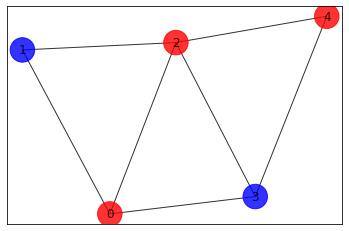

In [55]:
print(result)
plot_result(G, result.x)

## Questions?

# 5. An Application in Finance

## Portfolio Optimization
In the following, we consider a mean-variance portfolio optimization problem for $n$ assets:

$$
\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}
$$

where

- $x \in \{0, 1\}^n$ denotes which assets we buy,
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

In [56]:
from qiskit.finance.applications.ising import portfolio

In [57]:
# define tickers and number of assets
n = 6

# set budget
budget = n // 2

# sample expected returns and covariance matrix
mu, sigma = portfolio.random_model(n, seed=4321)

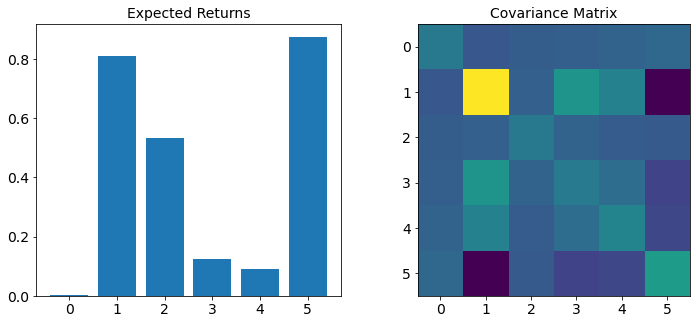

In [58]:
# plot mu/sigma
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title('Expected Returns', fontsize=14)
plt.bar(range(n), mu)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(1,2,2)
plt.title('Covariance Matrix', fontsize=14)
plt.imshow(sigma, interpolation='nearest')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [59]:
def get_qp(n, mu, sigma, budget, q):
    
    # create model with docplex
    mdl = Model('portfolio_optimization')

    # define variables: 
    #
    #     x_i in {0, 1}
    #
    x = mdl.binary_var_list(['x{}'.format(i) for i in range(n)])

    # set objective function: 
    #
    #     maximize { mu^T * x - q * x^T * sigma * x }
    #
    objective = mdl.sum([mu[i] * x[i] for i in range(n)])  # mu^T * x
    objective -= q * mdl.sum([sigma[i][j]*x[i]*x[j] for i in range(n) for j in range(n)])
    mdl.maximize(objective)

    # add budget constraint: 
    #
    #     1^T * x == budget
    #
    cost = mdl.sum([x[i] for i in range(n)])
    mdl.add_constraint(cost == budget, ctname='budget')

    # convert to quadratic program
    qp = QuadraticProgram()
    qp.from_docplex(mdl)
    
    return qp

In [60]:
# track resulting risk and return
mus = []
sigmas = []

# screen different risk factors
for q in [0, 1, 10]:
    
    # solve the portfolio optimization problem using QAOA
    qp = get_qp(n, mu, sigma, budget, q)
    result = qaoa.solve(qp)
    
    # track risk and return
    mus += [portfolio.portfolio_expected_value(result.x, mu)]
    sigmas += [portfolio.portfolio_variance(result.x, sigma)]
    
    # print resulting portfolio
    print(result.x)

[0. 1. 1. 0. 0. 1.]
[0. 0. 1. 1. 0. 1.]
[0. 0. 0. 1. 1. 1.]


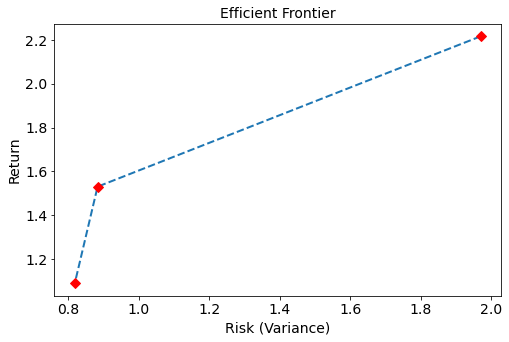

In [61]:
# plot risk/return efficient frontier
plt.figure(figsize=(8, 5))
plt.plot(sigmas, mus, '--', linewidth=2)
plt.plot(sigmas, mus, 'rD', markersize=7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Risk (Variance)', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.title('Efficient Frontier', fontsize=14)
plt.show()

## Questions?

# 6. What's next...

# Further Resources

<br>

- Medium article on Qiskit's Optimization module:<br>
https://medium.com/qiskit/ <br>
"A Walkthrough of Qiskit’s New Optimization Module"
<br>

- Qiskit Text Book:<br>
https://qiskit.org/textbook/ <br>
Sections on QAOA and Grover Search
<br>

- Qiskit Tutorials:<br>
https://qiskit.org/documentation/tutorials/optimization/ <br>
Tutorials on all algorithms, converters, etc.

# Next Steps...

- Test the existing optimization algorithms on your own problems.
- Check out additional algorithms, e.g. `RecursiveMinimumEigenOptimizer` and `ADMM`.
- Try first problems on real quantum devices.
- Contribute your own quantum optimization algorithms to Qiskit's Optimization module!

<div>
    <center>
        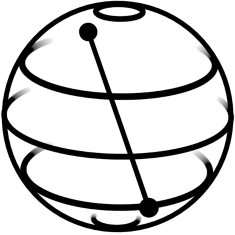
        <br>
        <br>
        Thank you!
    </center>
</div>